In [1]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.nn import Module, Parameter
from torch import FloatTensor
from scipy import signal
import numpy as np
from torchaudio import transforms
import matplotlib.pyplot as plt
import IPython.display as ipd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import os
from scipy import signal
import numpy as np
from pylab import *
import soundfile as sf
import matplotlib.pyplot as plt

# Declare Model

In [2]:
class FIRNN(Module):
    def __init__(self, n_input=1, n_output=1, kernel_size=1000, n_channel=32):
        super(FIRNN, self).__init__()        
        self.conv_kz = kernel_size
        self.input_len = 20000
        self.conv1 = nn.Conv1d(n_input, 1, kernel_size=kernel_size, stride=1)
        self.nonlinear = nn.Tanh()
        self.bn1 = nn.BatchNorm1d(n_channel)

        self.fc1 = nn.Conv1d(1, n_channel*2, kernel_size=1) 
        self.fc2 = nn.Conv1d(n_channel*2, 1, kernel_size=1)
        
        self.conv2 = nn.Conv1d(1, 1, kernel_size=kernel_size, stride=1)
        
        self.mlp_layer = nn.Sequential(
            self.fc1 ,
            nn.Tanh(),
            self.fc2,
        )


    def forward(self, x):
        #print(x.shape)
        bs = x.shape[0]
        
        x = F.pad(x, (self.conv_kz-1, 0)) #pad on the left side
        x = self.conv1(x) 
        #print(x.shape)
        #x = self.nonlinear(self.bn1(x))
        #print(x.shape)

        #x = x.view(bs, -1)
        x = self.mlp_layer(x)
        #x = self.layers(x)
        #print(x.shape)
        
        x = F.pad(x, (self.conv_kz-1, 0))
        x = self.conv2(x)
        #print(x.shape)

        return x


In [3]:
class DIIRDataSet(Dataset):
    def __init__(self, input, target, sequence_length):
        self.input = input
        self.target = target
        self._sequence_length = sequence_length
        self.input_sequence = self.wrap_to_sequences(self.input, self._sequence_length)
        self.target_sequence = self.wrap_to_sequences(self.target, self._sequence_length)
        self._len = self.input_sequence.shape[0]

    def __len__(self):
        return self._len

    def __getitem__(self, index):
        return {'input': self.input_sequence[index, :, :]
               ,'target': self.target_sequence[index, :, :]}

    def wrap_to_sequences(self, data, sequence_length):
        num_sequences = int(np.floor(data.shape[0] / sequence_length))
        print(num_sequences)
        truncated_data = data[0:(num_sequences * sequence_length)]
        wrapped_data = truncated_data.reshape((num_sequences, sequence_length, 1))
        wrapped_data = wrapped_data.permute(0,2,1)
        print(wrapped_data.shape)
        return np.float32(wrapped_data)

    

# Evaluate

In [4]:
model = FIRNN(kernel_size=1000, n_channel=32)

In [5]:
model_path = './models/model_fir_pure.pth'
model.load_state_dict(torch.load(model_path))
model.eval()

FIRNN(
  (conv1): Conv1d(1, 1, kernel_size=(1000,), stride=(1,))
  (nonlinear): Tanh()
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
  (fc2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(1, 1, kernel_size=(1000,), stride=(1,))
  (mlp_layer): Sequential(
    (0): Conv1d(1, 64, kernel_size=(1,), stride=(1,))
    (1): Tanh()
    (2): Conv1d(64, 1, kernel_size=(1,), stride=(1,))
  )
)

In [6]:
fir_weights = model.conv1.weight.detach().cpu().squeeze(1).numpy()
#fir_coefs = np.mean(fir_weights,0)

In [7]:
fir_weights.shape

(1, 1000)

In [8]:
fir_coefs = np.flip(fir_weights[0])

# Plot frequency response of the pure "FIR" filter

In [9]:
def freq_plot(b, a=1):
    w,h = signal.freqz(b,a)
    nyq_rate = 44100/2
    #print(len(w))
    h_dB = 20 * np.log10 (abs(h))
    
    #plt.plot(w/max(w), h_dB, linewidth=2)
    plt.plot((w/np.pi)*nyq_rate,h_dB, linewidth=2)
    plt.xlabel('Frequency (Hz)', fontsize=18)
    plt.ylabel('Gain (dB)', fontsize=18)
    plt.title('Frequency Response', fontsize=18)
    plt.ylim(-80, 20)
    plt.grid(alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.savefig('./figures/Frequency_response_pure_1conv.png', dpi=150)
    plt.show()

def phase_plot(b, a=1):
    w,h = signal.freqz(b,a)
    nyq_rate = 44100/2
    h_Phase = unwrap(arctan2(imag(h),real(h)))
    
    #plt.plot(w/max(w), h_Phase, c='orange')
    plt.plot((w/np.pi)*nyq_rate,h_Phase, c='orange')
    plt.ylabel('Phase (radians)', fontsize=18)
    plt.xlabel(r'Frequency (Hz)', fontsize=18)
    plt.title(r'Phase response', fontsize=18)
    plt.grid(alpha=0.4)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.savefig('./figures/Phase_response_pure_1conv.png', dpi=150)
    plt.show()

In [10]:
#Plot impulse response
def impz(b,a=1):
    l = len(b)
    impulse = repeat(0.,l); impulse[0] =1.
    x = arange(0,l)
    response = signal.lfilter(b,1,impulse)
    plt.plot(x, response)
    plt.grid(alpha=0.4)
    ylabel('Amplitude', fontsize=18)
    xlabel(r'n (samples)', fontsize=18)
    title(r'Impulse response', fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=16)
    plt.tight_layout()
    plt.savefig('./figures/impulse_response_pure_1conv.png', dpi=150)

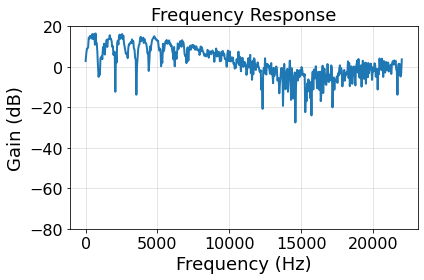

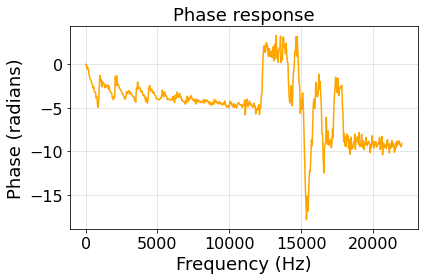

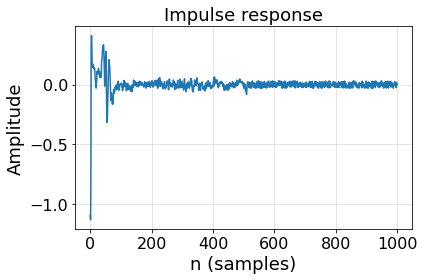

In [11]:
freq_plot(fir_coefs)
phase_plot(fir_coefs)
impz(fir_coefs)